# Obtain Intron TPMs of 100 nt within Intron-Exon Boundaries

This script will get the intron TPMs of 100 nt within the intron-exon boundaries. A ranked list is created of all non-zero regions ranked by TPMs in introns. This is done seperately for intron depth within 5' of exon-intron boundary and 3' exon-intron boundary. A combined list is also created. 
Histogram plots for intron depth distribution are created. 
Scatter plot for exon depth vs intron depth also created.

In [1]:
# import pandas as package
import pandas as pd
import os

In [2]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [4]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../processed_data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [5]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../processed_data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    print geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)
              0               1
0       DDX11L1     NR_046018.2
1        WASH7P     NR_024540.1
2   MIR1302-2HG  XR_001737835.1
3       FAM138A     NR_026818.1
4  LOC100996442  XR_001737582.2


In [6]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=0

In [7]:
# which end
whichend=str(5)

In [12]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/"):
    #if ("ExonIntron_"+whichend+"p_featureCounts_JustCounts" in filename and "Minus" in filename):
    if ("Minus" in filename and "JustCounts" in filename and "DropHeader" not in filename and "_Intron_"+whichend+"p" in filename):
        print filename
        # Read the salmon output file
        with open("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/"+filename) as f:
            lines = f.readlines()
        with open("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",'w') as fw:
            fw.writelines(lines[1:])
        data_to_read = pd.read_csv("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/"+filename.split('.')[0]+"_DropHeader.txt",header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        #print(data_to_read.head())
        print(data_to_read.shape)
        #transcriptIDs_with_introns = list(geneNamesAndTranscriptIDs_withIntrons[1].values)
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            feats_with_introns = data_to_read["Name"].str.split("_").str[0] + "_" + data_to_read["Name"].str.split("_").str[1]
            #print(feats_with_introns.head())
            data_to_read = data_to_read[feats_with_introns.isin(geneNamesAndTranscriptIDs_withIntrons[1])]
        print(data_to_read.shape)
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        print(data_to_read.shape)
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        # Sort the data by TPMs
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

AllMinus_Madrasin_Intron_5p_featureCounts_JustCounts.txt
(1252882, 3)
(1252882, 3)
(1069896, 3)


In [13]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

1069896


In [14]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if ("Minus" in filename and "JustCounts" in filename and "DropHeader" in filename):
        print filename
        current_columns.append(filename.split("_featureCounts")[0])
        data_to_read = pd.read_csv("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/"+filename,header=0,sep="\t")
        data_to_read.columns = ["Name","Length","Count"]
        # Calculate TPMs
        RPKs = 1000*(data_to_read["Count"]/data_to_read["Length"])
        total_RPKs = RPKs.sum()
        TPMs = 1000000*(RPKs/total_RPKs)
        data_to_read = data_to_read.assign(TPM=TPMs)
        transcriptIDs_for_data = data_to_read["Name"].str.split("_").str[0] + "_" + data_to_read["Name"].str.split("_").str[1]
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        print(data_GetFeatures.head())
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

AllMinus_Madrasin_ExonExon_5p_featureCounts_JustCounts_DropHeader.txt
                 Name  Length  Count       TPM
92   XM_024451962.1_1     101      0  0.000000
93   XM_024451963.1_2     101      0  0.000000
110  XM_024451962.1_4     101      0  0.000000
111  XM_024451963.1_4     101      0  0.000000
122  XM_011542538.1_1     101      1  3.195797
AllMinus_Madrasin_ExonExon_3p_featureCounts_JustCounts_DropHeader.txt
                 Name  Length  Count  TPM
93   XM_024451962.1_1     101      0  0.0
94   XM_024451963.1_2     101      0  0.0
111  XM_024451962.1_4     101      0  0.0
112  XM_024451963.1_4     101      0  0.0
122  XM_011542538.1_1     101      0  0.0
AllMinus_Madrasin_ExonIntron_5p_featureCounts_JustCounts_DropHeader.txt
                 Name  Length  Count       TPM
92   XM_024451962.1_1     201      0  0.000000
93   XM_024451963.1_2     201      0  0.000000
110  XM_024451962.1_4     201      0  0.000000
111  XM_024451963.1_4     201      0  0.000000
122  XM_011542538.1

In [15]:
#feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
#feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(1069896, 7)


,feature,AllMinus_Madrasin_ExonExon_5p,AllMinus_Madrasin_ExonExon_3p,AllMinus_Madrasin_ExonIntron_5p,AllMinus_Madrasin_Intron_5p,AllMinus_Madrasin_Intron_3p,AllMinus_Madrasin_ExonIntron_3p
0,NM_000014.5_10,0.0,0.0,0.0,0.0,0.0,0.0
1,NM_000014.5_11,0.0,0.0,0.0,0.0,0.0,0.0
2,NM_000014.5_12,0.0,0.0,0.0,0.0,0.0,0.0
3,NM_000014.5_13,0.0,0.0,0.0,0.0,0.0,0.0
4,NM_000014.5_14,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.loc[:,["feature","AllMinus_Madrasin_Intron_"+whichend+"p","AllMinus_Madrasin_ExonIntron_5p","AllMinus_Madrasin_ExonIntron_3p","AllMinus_Madrasin_ExonExon_5p","AllMinus_Madrasin_ExonExon_3p"]]
feature_readCounts_transcriptome.head()

,feature,AllMinus_Madrasin_Intron_5p,AllMinus_Madrasin_ExonIntron_5p,AllMinus_Madrasin_ExonIntron_3p,AllMinus_Madrasin_ExonExon_5p,AllMinus_Madrasin_ExonExon_3p
0,NM_000014.5_10,0.0,0.0,0.0,0.0,0.0
1,NM_000014.5_11,0.0,0.0,0.0,0.0,0.0
2,NM_000014.5_12,0.0,0.0,0.0,0.0,0.0
3,NM_000014.5_13,0.0,0.0,0.0,0.0,0.0
4,NM_000014.5_14,0.0,0.0,0.0,0.0,0.0


In [17]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.sort_values(by=["AllMinus_Madrasin_Intron_"+whichend+"p"],ascending=False)
feature_readCounts_transcriptome.head()

,feature,AllMinus_Madrasin_Intron_5p,AllMinus_Madrasin_ExonIntron_5p,AllMinus_Madrasin_ExonIntron_3p,AllMinus_Madrasin_ExonExon_5p,AllMinus_Madrasin_ExonExon_3p
236603,NM_001961.3_3,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735
237795,NM_002116.7_2,3192.153182,2523.103445,939.014796,2604.574464,911.571093
314088,NM_020529.2_2,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953
232442,NM_001402.5_5,2593.946770,2209.420314,657.028371,2518.287948,716.234430
236606,NM_001961.3_6,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717


In [18]:
### we need both geneID and transcriptID
data_transcriptsToGenes = pd.read_csv("../data/ExonIntronCoords_GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_"+whichend+"p.tsv",sep="\t",header=None)
print data_transcriptsToGenes.shape
data_transcriptsToGenes.head()

(1701899, 2)


,0,1
0,NM_000014.5_1,A2M
1,NM_000014.5_2,A2M
2,NM_000014.5_3,A2M
3,NM_000014.5_4,A2M
4,NM_000014.5_5,A2M


In [19]:
# Merge the two date sets
# Merge the two data sets
data_all = feature_readCounts_transcriptome.merge(data_transcriptsToGenes,left_on="feature",right_on=0)
print data_all.shape
data_all.head()

(1069896, 8)


,feature,AllMinus_Madrasin_Intron_5p,AllMinus_Madrasin_ExonIntron_5p,AllMinus_Madrasin_ExonIntron_3p,AllMinus_Madrasin_ExonExon_5p,AllMinus_Madrasin_ExonExon_3p,0,1
0,NM_001961.3_3,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735,NM_001961.3_3,EEF2
1,NM_002116.7_2,3192.153182,2523.103445,939.014796,2604.574464,911.571093,NM_002116.7_2,HLA-A
2,NM_020529.2_2,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953,NM_020529.2_2,NFKBIA
3,NM_001402.5_5,2593.946770,2209.420314,657.028371,2518.287948,716.234430,NM_001402.5_5,EEF1A1
4,NM_001961.3_6,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717,NM_001961.3_6,EEF2


In [20]:
# Load the dataset for transcript ID coords
dataCoords_TranscriptIDs = pd.read_csv("../data/SAFformat_ExtractedIntronCoordinatesFromGFFfile_"+whichend+"p_OnlyTranscriptIDs.bed",sep="\t",header=0)
dataCoords_TranscriptIDs.head()

,GeneID,Chr,Start,End,Strand
0,NR_046018.2_1,chr1,12228,12327,+
1,NR_046018.2_2,chr1,12722,12821,+
2,NR_024540.1_1,chr1,14870,14969,-
3,NR_024540.1_2,chr1,15696,15795,-
4,NR_024540.1_3,chr1,16507,16606,-


In [21]:
dataCoords_TranscriptIDs_onlyRelevant = dataCoords_TranscriptIDs[dataCoords_TranscriptIDs["GeneID"].isin(data_all["feature"])]
print(dataCoords_TranscriptIDs_onlyRelevant.shape)
dataCoords_TranscriptIDs_onlyRelevant.head()

(1069896, 5)


,GeneID,Chr,Start,End,Strand
60,XM_024451962.1_1,chr1,357949,358048,-
61,XM_024451963.1_2,chr1,357949,358048,-
69,XM_024451962.1_4,chr1,379669,379768,-
70,XM_024451963.1_4,chr1,379669,379768,-
76,XM_011542538.1_1,chr1,586721,586820,-


In [22]:
# Merge coord data with featureCounts
data_all_coords = data_all.merge(dataCoords_TranscriptIDs_onlyRelevant,left_on="feature",right_on="GeneID")
print data_all_coords.shape
data_all_coords.head()

(1069896, 13)


,feature,AllMinus_Madrasin_Intron_5p,AllMinus_Madrasin_ExonIntron_5p,AllMinus_Madrasin_ExonIntron_3p,AllMinus_Madrasin_ExonExon_5p,AllMinus_Madrasin_ExonExon_3p,0,1,GeneID,Chr,Start,End,Strand
0,NM_001961.3_3,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735,NM_001961.3_3,EEF2,NM_001961.3_3,chr19,3977719,3977818,-
1,NM_002116.7_2,3192.153182,2523.103445,939.014796,2604.574464,911.571093,NM_002116.7_2,HLA-A,NM_002116.7_2,chr6,29943027,29943126,+
2,NM_020529.2_2,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953,NM_020529.2_2,NFKBIA,NM_020529.2_2,chr14,35402671,35402770,-
3,NM_001402.5_5,2593.946770,2209.420314,657.028371,2518.287948,716.234430,NM_001402.5_5,EEF1A1,NM_001402.5_5,chr6,73519237,73519336,-
4,NM_001961.3_6,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717,NM_001961.3_6,EEF2,NM_001961.3_6,chr19,3980414,3980513,-


In [23]:
# Get relevant columns and arrange correctly
data_to_write = data_all_coords.iloc[:,[7,8,9,10,11,12,1,2,3,4,5]]
data_to_write.head()

,1,GeneID,Chr,Start,End,Strand,AllMinus_Madrasin_Intron_5p,AllMinus_Madrasin_ExonIntron_5p,AllMinus_Madrasin_ExonIntron_3p,AllMinus_Madrasin_ExonExon_5p,AllMinus_Madrasin_ExonExon_3p
0,EEF2,NM_001961.3_3,chr19,3977719,3977818,-,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735
1,HLA-A,NM_002116.7_2,chr6,29943027,29943126,+,3192.153182,2523.103445,939.014796,2604.574464,911.571093
2,NFKBIA,NM_020529.2_2,chr14,35402671,35402770,-,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953
3,EEF1A1,NM_001402.5_5,chr6,73519237,73519336,-,2593.946770,2209.420314,657.028371,2518.287948,716.234430
4,EEF2,NM_001961.3_6,chr19,3980414,3980513,-,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717


In [26]:
data_to_write.columns = ["Gene","TranscriptID","Chr","Start","End","Strand","Intron_"+whichend+"p_TPMs","ExonIntron_5p_TPMs","ExonIntron_3p_TPMs","ExonExon_5p_TPMs","ExonExon_3p_TPMs"]
data_to_write.head()

,Gene,TranscriptID,Chr,Start,End,Strand,Intron_5p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
0,EEF2,NM_001961.3_3,chr19,3977719,3977818,-,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735
1,HLA-A,NM_002116.7_2,chr6,29943027,29943126,+,3192.153182,2523.103445,939.014796,2604.574464,911.571093
2,NFKBIA,NM_020529.2_2,chr14,35402671,35402770,-,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953
3,EEF1A1,NM_001402.5_5,chr6,73519237,73519336,-,2593.946770,2209.420314,657.028371,2518.287948,716.234430
4,EEF2,NM_001961.3_6,chr19,3980414,3980513,-,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717


In [32]:
data_to_write.tail(n=100)

,Gene,TranscriptID,Chr,Start,End,Strand,Intron_5p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
1069796,ZNF827,NM_178835.4_8,chr4,145845856,145845955,-,0.0,0.0,0.0,0.0,0.0
1069797,ZNF827,NM_178835.4_9,chr4,145849222,145849321,-,0.0,0.0,0.0,0.0,0.0
1069798,DNAAF3,NM_178837.4_2,chr19,55159799,55159898,-,0.0,0.0,0.0,0.0,0.0
1069799,CASTOR3,NM_178831.6_2,chr7,100223782,100223881,-,0.0,0.0,0.0,0.0,0.0
1069800,SPATA31E1,NM_178828.4_3,chr9,87884652,87884751,+,0.0,0.0,0.0,0.0,0.0
1069801,DNAAF3,NM_178837.4_7,chr19,55162033,55162132,-,0.0,0.0,0.0,0.0,0.0
1069802,ANO4,NM_178826.3_3,chr12,100939452,100939551,+,0.0,0.0,0.0,0.0,0.0
1069803,ANO4,NM_178826.3_12,chr12,101043636,101043735,+,0.0,0.0,0.0,0.0,0.0
1069804,ANO4,NM_178826.3_14,chr12,101079276,101079375,+,0.0,0.0,0.0,0.0,0.0
1069805,ANO4,NM_178826.3_15,chr12,101083819,101083918,+,0.0,0.0,0.0,0.0,0.0


In [78]:
data_to_write_GreaterThanZero = data_to_write[data_to_write["Intron_3p_TPMs"]>0]
print(data_to_write_GreaterThanZero.shape)
data_to_write_GreaterThanZero.head()

(18679, 11)


,Gene,TranscriptID,Chr,Start,End,Strand,Intron_3p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
0,ACTB,NM_001101.4_3,chr7,5528720,5528819,-,4863.163038,3715.099342,8352.437914,4231.235080,9509.639864
1,EEF2,NM_001961.3_6,chr19,3980067,3980166,-,3116.112051,2015.755076,2780.386152,2010.156243,3040.740717
2,EEF2,NM_001961.3_4,chr19,3978173,3978272,-,3000.871221,804.665423,2746.547781,949.151676,3073.296827
3,EEF2,NM_001961.3_13,chr19,3983292,3983391,-,2922.507456,1456.580799,1751.135700,1559.548881,2340.784342
4,EEF2,NM_001961.3_3,chr19,3977611,3977710,-,2668.977629,2997.719660,1804.713121,3333.216154,2103.124735


In [79]:
data_to_write_GreaterThanZero.to_csv("../tmp/Intron_3p_100bpPlusBoundaries_SortedByTPM.csv",sep=",",header=True,index=False)

In [82]:
# Combine the 5'p and 3'p ends
fivep = pd.read_csv("../tmp/Intron_5p_100bpPlusBoundaries_SortedByTPM.csv",sep=",",header=0)
fivep.columns = ["Gene","TranscriptID","Chr","Start","End","Strand","Intron_TPMs","ExonIntron_5p_TPMs","ExonIntron_3p_TPMs","ExonExon_5p_TPMs","ExonExon_3p_TPMs"]
print(fivep.head())
threep = pd.read_csv("../tmp/Intron_3p_100bpPlusBoundaries_SortedByTPM.csv",sep=",",header=0)
threep.columns = ["Gene","TranscriptID","Chr","Start","End","Strand","Intron_TPMs","ExonIntron_5p_TPMs","ExonIntron_3p_TPMs","ExonExon_5p_TPMs","ExonExon_3p_TPMs"]
print(threep.head())

     Gene   TranscriptID    Chr     Start       End Strand  Intron_TPMs  \
0    EEF2  NM_001961.3_3  chr19   3977719   3977818      -  3233.408797   
1   HLA-A  NM_002116.7_2   chr6  29943027  29943126      +  3192.153182   
2  NFKBIA  NM_020529.2_2  chr14  35402671  35402770      -  2624.888481   
3  EEF1A1  NM_001402.5_5   chr6  73519237  73519336      -  2593.946770   
4    EEF2  NM_001961.3_6  chr19   3980414   3980513      -  2563.005059   

   ExonIntron_5p_TPMs  ExonIntron_3p_TPMs  ExonExon_5p_TPMs  ExonExon_3p_TPMs  
0         2997.719660         1804.713121       3333.216154       2103.124735  
1         2523.103445          939.014796       2604.574464        911.571093  
2         1582.054052         2230.512623       1629.856413       2344.039953  
3         2209.420314          657.028371       2518.287948        716.234430  
4         2015.755076         2780.386152       2010.156243       3040.740717  
   Gene    TranscriptID    Chr    Start      End Strand  Intron_TPMs 

In [84]:
all_introns_data = pd.concat([fivep,threep],axis=0)
print(all_introns_data.shape)
all_introns_data.head()

(36932, 11)


,Gene,TranscriptID,Chr,Start,End,Strand,Intron_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
0,EEF2,NM_001961.3_3,chr19,3977719,3977818,-,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735
1,HLA-A,NM_002116.7_2,chr6,29943027,29943126,+,3192.153182,2523.103445,939.014796,2604.574464,911.571093
2,NFKBIA,NM_020529.2_2,chr14,35402671,35402770,-,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953
3,EEF1A1,NM_001402.5_5,chr6,73519237,73519336,-,2593.946770,2209.420314,657.028371,2518.287948,716.234430
4,EEF2,NM_001961.3_6,chr19,3980414,3980513,-,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717


In [85]:
all_introns_data_sorted = all_introns_data.sort_values(by=["Intron_TPMs"],ascending=False)
all_introns_data_sorted.head()

,Gene,TranscriptID,Chr,Start,End,Strand,Intron_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
0,ACTB,NM_001101.4_3,chr7,5528720,5528819,-,4863.163038,3715.099342,8352.437914,4231.235080,9509.639864
0,EEF2,NM_001961.3_3,chr19,3977719,3977818,-,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735
1,HLA-A,NM_002116.7_2,chr6,29943027,29943126,+,3192.153182,2523.103445,939.014796,2604.574464,911.571093
1,EEF2,NM_001961.3_6,chr19,3980067,3980166,-,3116.112051,2015.755076,2780.386152,2010.156243,3040.740717
2,EEF2,NM_001961.3_4,chr19,3978173,3978272,-,3000.871221,804.665423,2746.547781,949.151676,3073.296827


In [86]:
all_introns_data_sorted.to_csv("../tmp/Intron_all_100bpPlusBoundaries_SortedByTPM.csv",sep=",",header=True,index=False)

In [148]:
data_loaded_all = pd.read_csv("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/Intron_5p_100bpPlusBoundaries_SortedByTPM.csv",sep=",",header=0)
print(data_loaded_all.shape)
data_loaded_all.head()

(18253, 11)


,Gene,TranscriptID,Chr,Start,End,Strand,Intron_5p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
0,EEF2,NM_001961.3_3,chr19,3977719,3977818,-,3233.408797,2997.719660,1804.713121,3333.216154,2103.124735
1,HLA-A,NM_002116.7_2,chr6,29943027,29943126,+,3192.153182,2523.103445,939.014796,2604.574464,911.571093
2,NFKBIA,NM_020529.2_2,chr14,35402671,35402770,-,2624.888481,1582.054052,2230.512623,1629.856413,2344.039953
3,EEF1A1,NM_001402.5_5,chr6,73519237,73519336,-,2593.946770,2209.420314,657.028371,2518.287948,716.234430
4,EEF2,NM_001961.3_6,chr19,3980414,3980513,-,2563.005059,2015.755076,2780.386152,2010.156243,3040.740717


In [149]:
# Load R GGplots
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(reshape)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array([1], dtype=int32)

[1] "../results/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/GGplot2-FrequencyTPMValsIn5pIntrons_PooledMinusDMSPlusMadrasin.png"


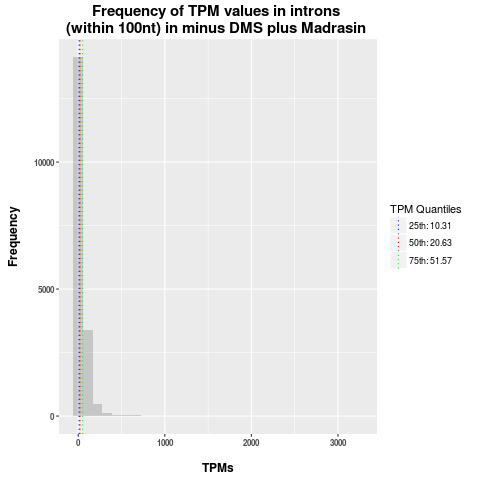

In [156]:
%%R -i data_loaded_all
med_tmp = median(data_loaded_all$Intron_5p_TPMs)
quantile_75 = quantile(data_loaded_all$Intron_5p_TPMs,0.75)
quantile_25 = quantile(data_loaded_all$Intron_5p_TPMs,0.25)
vertDf<-data.frame(years=c(med_tmp,quantile_75,quantile_25),labels=c(paste("50th",": ",round(med_tmp,2),sep=""),paste("75th",": ",round(quantile_75,2),sep=""),
                                                                     paste("25th",": ",round(quantile_25,2),sep="")))
p<- ggplot(data_loaded_all, aes(x=Intron_5p_TPMs)) +
  geom_histogram(alpha=0.25) +
    geom_vline(aes(xintercept=years,color=labels),data=vertDf,linetype="dotted",size=0.5,show_guide=T) +
    scale_color_manual("TPM Quantiles",
                     values=c("blue","red","green")) +
    ggtitle("Frequency of TPM values in introns \n(within 100nt) in minus DMS plus Madrasin ") +
    xlab("\nTPMs") +
    ylab("Frequency\n") +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         plot.title = element_text(face="bold",size=15))
filenameToSave = paste("../results/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/GGplot2-FrequencyTPMValsIn5pIntrons_PooledMinusDMSPlusMadrasin.png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

[1] "../results/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/GGplot2-FrequencyTPMValsIn5pIntrons_PooledMinusDMSPlusMadrasin_ZoomedIn.png"


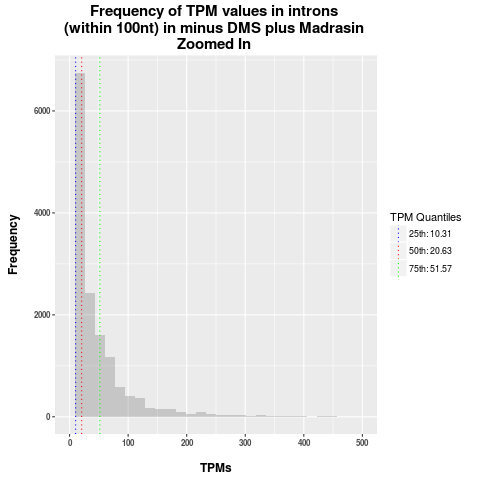

In [157]:
%%R -i data_loaded_all
med_tmp = median(data_loaded_all$Intron_5p_TPMs)
quantile_75 = quantile(data_loaded_all$Intron_5p_TPMs,0.75)
quantile_25 = quantile(data_loaded_all$Intron_5p_TPMs,0.25)
vertDf<-data.frame(years=c(med_tmp,quantile_75,quantile_25),labels=c(paste("50th",": ",round(med_tmp,2),sep=""),paste("75th",": ",round(quantile_75,2),sep=""),
                                                                     paste("25th",": ",round(quantile_25,2),sep="")))
p<- ggplot(data_loaded_all, aes(x=Intron_5p_TPMs)) +
  geom_histogram(alpha=0.25) +
    xlim(0,500) +
    geom_vline(aes(xintercept=years,color=labels),data=vertDf,linetype="dotted",size=0.5,show_guide=T) +
    scale_color_manual("TPM Quantiles",
                     values=c("blue","red","green")) +
    ggtitle("Frequency of TPM values in introns \n(within 100nt) in minus DMS plus Madrasin \nZoomed In ") +
    xlab("\nTPMs") +
    ylab("Frequency\n") +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         plot.title = element_text(face="bold",size=15))
filenameToSave = paste("../results/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/GGplot2-FrequencyTPMValsIn5pIntrons_PooledMinusDMSPlusMadrasin_ZoomedIn.png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

[1] "../results/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/GGplot2-ScatterPlot_IntronVsExonDepth_5p_PooledMinusDMSPlusMadrasin_ZoomedIn.png"


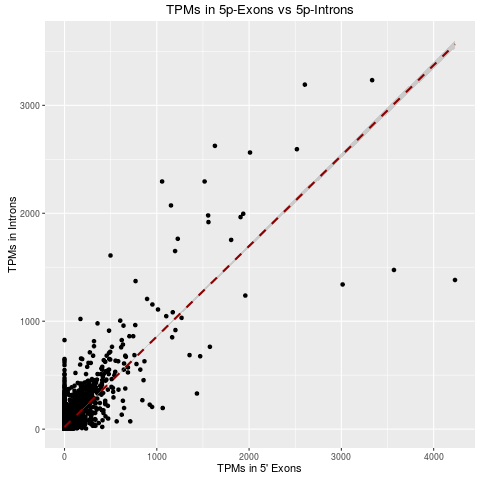

In [155]:
%%R -i data_loaded_all
p<- ggplot(data_loaded_all, aes(x=ExonExon_5p_TPMs,y=Intron_5p_TPMs)) +
  geom_point() +
    geom_smooth(method=lm,linetype="dashed",color="darkred") +
    #ggtitle(paste("Frequency of MAPQ values for\n Plus and Minus DMS",sampleName,sep=" ")) +
    xlab("TPMs in 5' Exons") +
    ylab("TPMs in Introns") +
    ggtitle("TPMs in 5p-Exons vs 5p-Introns")
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         plot.title = element_text(face="bold",size=15))
filenameToSave = paste("../results/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/GGplot2-ScatterPlot_IntronVsExonDepth_5p_PooledMinusDMSPlusMadrasin_ZoomedIn.png",sep="")
print(filenameToSave)
ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

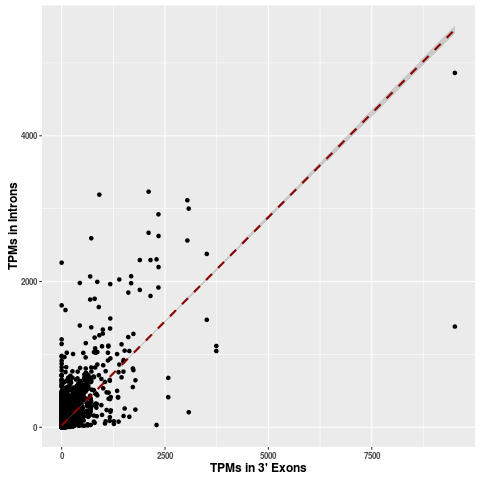

In [147]:
%%R -i data_loaded_all
p<- ggplot(data_loaded_all, aes(x=ExonExon_3p_TPMs,y=Intron_TPMs)) +
  geom_point() +
    geom_smooth(method=lm,linetype="dashed",color="darkred") +
    #ggtitle(paste("Frequency of MAPQ values for\n Plus and Minus DMS",sampleName,sep=" ")) +
    xlab("TPMs in 3' Exons") +
    ylab("TPMs in Introns") +
    theme(axis.title.x=element_text(face="bold",size=12),axis.title.y=element_text(face="bold",size=12),
          axis.text.x = element_text(face="bold",size=8),axis.text.y = element_text(face="bold",size=8),
         plot.title = element_text(face="bold",size=15))
#filenameToSave = paste("../results/",folderName,"/GGplot2-FrequencyMAPQvalsPlusMinusDMS-",sampleName,".png",sep="")
#print(filenameToSave)
#ggsave(p,file=filenameToSave,width=8.1,height=5.6,dpi=300)
p

### Get number of mutations data and add it to the intron TPM data

In [2]:
end="3p"

In [3]:
exonintron_Intersect_Muts = pd.read_csv("../processed_data/ExonIntronCoordinates_"+end+"_FromGFFfile_50bpWindow_IncludingNumberOfIntersectedMuts.txt",sep="\t",header=None)
exonintron_Intersect_Muts.head()

,0,1,2,3,4,5,6
0,chr11,5226774,5226824,NM_000518.4_2,-,42,HBB
1,chr2,47403335,47403385,NM_001258281.1_1,+,40,MSH2
2,chr11,5225701,5225751,NM_000518.4_1,-,36,HBB
3,chr17,43063348,43063398,NM_007299.3_5,-,35,BRCA1
4,chr17,43063348,43063398,NR_027676.1_6,-,35,BRCA1


In [4]:
# Get names of transcriptIDs that have muts within them
transcriptIDs_withMuts = exonintron_Intersect_Muts[3]
print(len(transcriptIDs_withMuts))

198513


In [5]:
# Read in the intron data with TPMs
introndata_loaded_all = pd.read_csv("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/Intron_"+end+"_100bpPlusBoundaries_SortedByTPM.csv",sep=",",header=0)
print(introndata_loaded_all.shape)
introndata_loaded_all.head()

(18679, 11)


,Gene,TranscriptID,Chr,Start,End,Strand,Intron_3p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs
0,ACTB,NM_001101.4_3,chr7,5528720,5528819,-,4863.163038,3715.099342,8352.437914,4231.235080,9509.639864
1,EEF2,NM_001961.3_6,chr19,3980067,3980166,-,3116.112051,2015.755076,2780.386152,2010.156243,3040.740717
2,EEF2,NM_001961.3_4,chr19,3978173,3978272,-,3000.871221,804.665423,2746.547781,949.151676,3073.296827
3,EEF2,NM_001961.3_13,chr19,3983292,3983391,-,2922.507456,1456.580799,1751.135700,1559.548881,2340.784342
4,EEF2,NM_001961.3_3,chr19,3977611,3977710,-,2668.977629,2997.719660,1804.713121,3333.216154,2103.124735


In [6]:
# Get the intron IDs for the TPMs
transcriptIDs_withTPMs = introndata_loaded_all["TranscriptID"]
print(len(transcriptIDs_withTPMs))

18679


In [8]:
# Get the overlap for the two
transcriptIDs_TPMsandMuts = transcriptIDs_withTPMs[transcriptIDs_withTPMs.isin(transcriptIDs_withMuts)]
print(len(transcriptIDs_TPMsandMuts))

1850


In [9]:
# Get the transcriptIDs that don't have muts in them
transcriptIDs_TPMsandNoMuts = transcriptIDs_withTPMs[~transcriptIDs_withTPMs.isin(transcriptIDs_withMuts)]
print(len(transcriptIDs_TPMsandNoMuts))

16829


In [10]:
# make a dataframe for the transcriptIDs that don't have muts in them
transcriptIDs_TPMsandNoMuts_DF = pd.DataFrame({"transcriptIDs":transcriptIDs_TPMsandNoMuts,"numMuts":[0]*len(transcriptIDs_TPMsandNoMuts)},columns=["transcriptIDs","numMuts"])
transcriptIDs_TPMsandNoMuts_DF.head()

,transcriptIDs,numMuts
1,NM_001961.3_6,0
2,NM_001961.3_4,0
3,NM_001961.3_13,0
4,NM_001961.3_3,0
6,XM_017013884.1_1,0


In [12]:
# make a dataframe for the transcriptIDs that don't have muts in them
exonintron_Intersect_Muts_SubsetWithTPMs = exonintron_Intersect_Muts[exonintron_Intersect_Muts[3].isin(transcriptIDs_TPMsandMuts)]
print(exonintron_Intersect_Muts_SubsetWithTPMs.shape)
transcriptIDs_TPMsandMuts_DF = pd.DataFrame({"transcriptIDs":exonintron_Intersect_Muts_SubsetWithTPMs[3],"numMuts":exonintron_Intersect_Muts_SubsetWithTPMs[5]},columns=["transcriptIDs","numMuts"])
transcriptIDs_TPMsandMuts_DF.head()

(1850, 7)


,transcriptIDs,numMuts
7,NM_000059.3_15,35
19,NM_000551.3_2,34
73,NM_000059.3_2,30
103,XM_005251343.1_2,29
120,NM_001354906.1_9,28


In [13]:
# Concatenate the two dataframes together
transcriptIDs_TPMsandPlusMinusMuts_DF = pd.concat([transcriptIDs_TPMsandNoMuts_DF,transcriptIDs_TPMsandMuts_DF])
print(transcriptIDs_TPMsandPlusMinusMuts_DF.shape)
transcriptIDs_TPMsandPlusMinusMuts_DF.head()

(18679, 2)


,transcriptIDs,numMuts
1,NM_001961.3_6,0
2,NM_001961.3_4,0
3,NM_001961.3_13,0
4,NM_001961.3_3,0
6,XM_017013884.1_1,0


In [14]:
# Merge intron TPM data with number of mutations data
introndata_mergedMutData = introndata_loaded_all.merge(transcriptIDs_TPMsandPlusMinusMuts_DF,left_on="TranscriptID",right_on="transcriptIDs")
print(introndata_mergedMutData.shape)
introndata_mergedMutData.head()

(18679, 13)


,Gene,TranscriptID,Chr,Start,End,Strand,Intron_3p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs,transcriptIDs,numMuts
0,ACTB,NM_001101.4_3,chr7,5528720,5528819,-,4863.163038,3715.099342,8352.437914,4231.235080,9509.639864,NM_001101.4_3,1
1,EEF2,NM_001961.3_6,chr19,3980067,3980166,-,3116.112051,2015.755076,2780.386152,2010.156243,3040.740717,NM_001961.3_6,0
2,EEF2,NM_001961.3_4,chr19,3978173,3978272,-,3000.871221,804.665423,2746.547781,949.151676,3073.296827,NM_001961.3_4,0
3,EEF2,NM_001961.3_13,chr19,3983292,3983391,-,2922.507456,1456.580799,1751.135700,1559.548881,2340.784342,NM_001961.3_13,0
4,EEF2,NM_001961.3_3,chr19,3977611,3977710,-,2668.977629,2997.719660,1804.713121,3333.216154,2103.124735,NM_001961.3_3,0


In [15]:
# Sort by number of mutations and TPMs
introndata_mergedMutData_sortedByMuts = introndata_mergedMutData.sort_values(by=["numMuts"],ascending=False)
introndata_mergedMutData_sortedByMuts.head()

,Gene,TranscriptID,Chr,Start,End,Strand,Intron_3p_TPMs,ExonIntron_5p_TPMs,ExonIntron_3p_TPMs,ExonExon_5p_TPMs,ExonExon_3p_TPMs,transcriptIDs,numMuts
12171,BRCA2,NM_000059.3_15,chr13,32357642,32357741,+,13.828900,8.183038,8.459593,6.391594,9.766833,NM_000059.3_15,35
709,VHL,NM_000551.3_2,chr3,10149687,10149786,+,179.775695,46.370550,0.000000,51.132750,0.000000,NM_000551.3_2,34
10890,BRCA2,NM_000059.3_2,chr13,32318977,32319076,+,18.438533,19.093756,19.739050,22.370578,22.789277,NM_000059.3_2,30
8255,CDKN2A,XM_005251343.1_2,chr9,21971209,21971308,-,27.657799,2.727679,0.000000,3.195797,0.000000,XM_005251343.1_2,29
11221,APC,NM_001354906.1_9,chr5,112815395,112815494,+,13.828900,0.000000,0.000000,0.000000,0.000000,NM_001354906.1_9,28


In [16]:
# Write the sorted file 
introndata_mergedMutData_sortedByMuts.iloc[:,[0,1,2,3,4,5,6,7,8,9,10,12]].to_csv("../tmp/ShapeMapper2Parms_Bowtie2Alignment_Lela_MadrasinReadsTest_June2018/Intron_"+end+"_100bpPlusBoundaries_SortedByNumMutations.csv",sep=",",header=True,index=False)